In [1]:
import numpy as np
from sympy import *
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
init_printing()

### Helpers

Create rotational matrix generator.

In [2]:
def rotate(p, theta, o, direction):
    """
    Rotate a point about an direction through a point.
    Represents a counterclockwise rotation by theta about the line passing through point pointing in direction.
    :param p: The point to be rotated.
    :param theta: How much to rotate p.
    :param o: The origin of the rotational axis.
    :param direction: The direction of the rotational axis.
    """
    
    # Ensure direction is matrix (for norm).
    direction = Matrix(direction)
    
    # Unpack.
    u, v, w = direction / direction.norm()
    x, y, z = p
    a, b, c = o
    
    x1 = (a*(v**2+w**2)-u*(b*v+c*w-u*x-v*y-w*z))*(1-cos(theta))+x*cos(theta)+(-c*v+b*w-w*y+v*z)*sin(theta)
    y1 = (b*(u**2+w**2)-v*(a*u+c*w-u*x-v*y-w*z))*(1-cos(theta))+y*cos(theta)+(c*u-a*w+w*x-u*z)*sin(theta)
    z1 = (c*(u**2+v**2)-w*(a*u+b*v-u*x-v*y-w*z))*(1-cos(theta))+z*cos(theta)+(-b*u+a*v-v*x+u*y)*sin(theta)
    
    return Matrix((x1, y1, z1))

Create pretty simplification function.

In [3]:
def pretty(eqn, expressions, symbols):
    """
    Does pretty simplification by replacing expressions in a expression or matrix with symbols.
    :param eqn: The desired input expression or matrix.
    :param expressions: The expressions to replace.
    :param symbols: The symbols to use.
    """
    
    eqn = eqn.copy()

    for expr, sub in zip(expressions, symbols):
        eqn = eqn.subs(expr, sub)
        
    return simplify(eqn)

Create plotting functions.

In [231]:
def equal_ax(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)
     
    
def plot_arm(points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    xs, ys, zs = zip(*points)
    ax.plot(xs, ys, zs, 'go-')
    
    ax.view_init(30, 150)
    equal_ax(ax)
    
    plt.show()

### Preliminary Tests

Run test cases for rotations about origin. Ensure that the rotate function works.

In [5]:
theta = Symbol('theta')
nx = (1, 0, 0)
ny = (0, 1, 0)
nz = (0, 0, 1)
o = (0, 0, 0)

In [6]:
# Rotate p about x.
p = Matrix((1, 0, 0))
rotate(p, theta, o, nx)

⎡1⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

In [7]:
# Rotate p about y.
p = Matrix((1, 0, 0))
rotate(p, theta, o, ny)

⎡cos(θ) ⎤
⎢       ⎥
⎢   0   ⎥
⎢       ⎥
⎣-sin(θ)⎦

In [8]:
# Rotate p about z.
p = Matrix((1, 0, 0))
rotate(p, theta, o, nz)

⎡cos(θ)⎤
⎢      ⎥
⎢sin(θ)⎥
⎢      ⎥
⎣  0   ⎦

### Forward Kinematics

Define lengths for arm segments. Graph points for base condition.

<IPython.core.display.Javascript object>


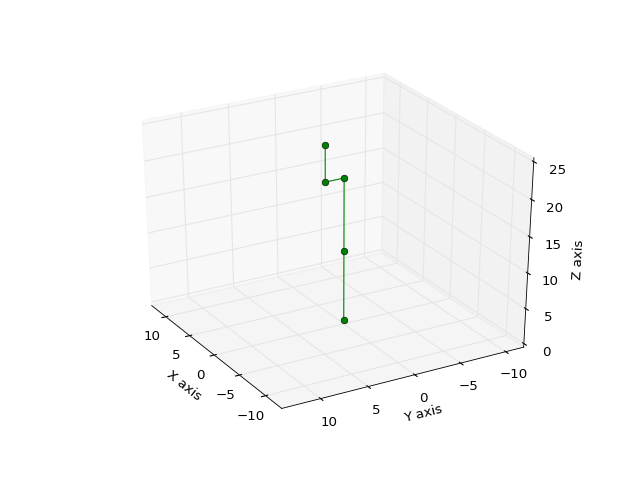

In [9]:
l1 = 10
l2 = 10
l3 = 2
l4 = 5

p0 = (0, 0, 0)
p1 = (0, 0, l1)
p2 = (0, 0, l1 + l2)
p3 = (0, l3, l1 + l2)
p4 = (0, l3, l1 + l2 + l4)

points = [p0, p1, p2, p3, p4]

plot_arm(points)

Define all variables and angles. $l_3$ can be negative depending on design and assembly.

In [158]:
theta1, theta2, theta3, theta4, l3 = symbols('theta_1 theta_2 theta_3 theta_4 l_3', real=True)
l1, l2, l4 = symbols('l_1 l_2 l_4', positive=True)

o0 = (0, 0, 0)
o1 = (0, 0, l1)
o3 = (0, l3, l1 + l2)

Solving for $p_0$ is trivial. It is always at the defined origin.

In [11]:
p0 = Matrix((0, 0, 0))
p0

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

To solve for $p_1$, account for $\theta_1$ and $\theta_2$.

In [12]:
p1 = Matrix((0, 0, l1))
p1_sym = symbols('p_1x p_1y p_1z')

p1 = rotate(p1, theta2, o0, ny)
p1 = rotate(p1, theta1, o0, nz)

p1 = p1.expand()

simplify(p1)

⎡l₁⋅sin(θ₂)⋅cos(θ₁)⎤
⎢                  ⎥
⎢l₁⋅sin(θ₁)⋅sin(θ₂)⎥
⎢                  ⎥
⎣    l₁⋅cos(θ₂)    ⎦

To solve for $p_2$, account for $\theta_1$ through $\theta_3$ (inclusive).

In [13]:
p2 = Matrix((0, 0, l1 + l2))
p2_sym = symbols('p_2x p_2y p_2z')

p2 = rotate(p2, theta3, o1, ny)
p2 = rotate(p2, theta2, o0, ny)
p2 = rotate(p2, theta1, o0, nz)

p2 = p2.expand()

pretty(p2, p1, p1_sym)

⎡l₂⋅sin(θ₂ + θ₃)⋅cos(θ₁) + p₁ₓ ⎤
⎢                              ⎥
⎢l₂⋅sin(θ₁)⋅sin(θ₂ + θ₃) + p_1y⎥
⎢                              ⎥
⎣    l₂⋅cos(θ₂ + θ₃) + p_1z    ⎦

To solve for $p_3$, account for the same rotations as $p_2$.

In [14]:
p3 = Matrix((0, l3, l1 + l2))
p3_sym = symbols('p_3x p_3y p_3z')

p3 = rotate(p3, theta3, o1, ny)
p3 = rotate(p3, theta2, o0, ny)
p3 = rotate(p3, theta1, o0, nz)

p3 = p3.expand()

pretty(p3, p2, p2_sym)

⎡-l₃⋅sin(θ₁) + p₂ₓ⎤
⎢                 ⎥
⎢l₃⋅cos(θ₁) + p_2y⎥
⎢                 ⎥
⎣      p_2z       ⎦

To solve for $p_4$, account for the all rotations.

In [15]:
p4 = Matrix((0, l3, l1 + l2 + l4))

p4 = rotate(p4, theta4, o3, ny)
p4 = rotate(p4, theta3, o1, ny)
p4 = rotate(p4, theta2, o0, ny)
p4 = rotate(p4, theta1, o0, nz)

p4 = p4.expand()

pretty(p4, p3, p3_sym)

⎡l₄⋅sin(θ₂ + θ₃ + θ₄)⋅cos(θ₁) + p₃ₓ ⎤
⎢                                   ⎥
⎢l₄⋅sin(θ₁)⋅sin(θ₂ + θ₃ + θ₄) + p_3y⎥
⎢                                   ⎥
⎣    l₄⋅cos(θ₂ + θ₃ + θ₄) + p_3z    ⎦

Graph some test conditions.

In [16]:
def graph_fk(lengths, angles):
    sub = [(theta1, angles[0]), (theta2, angles[1]), (theta3, angles[2]), (theta4, angles[3]),
           (l1, lengths[0]), (l2, lengths[1]), (l3, lengths[2]), (l4, lengths[3])]
    points = [p0, p1.subs(sub), p2.subs(sub), p3.subs(sub), p4.subs(sub)]
    
    plot_arm(points)
    
    return points

<IPython.core.display.Javascript object>


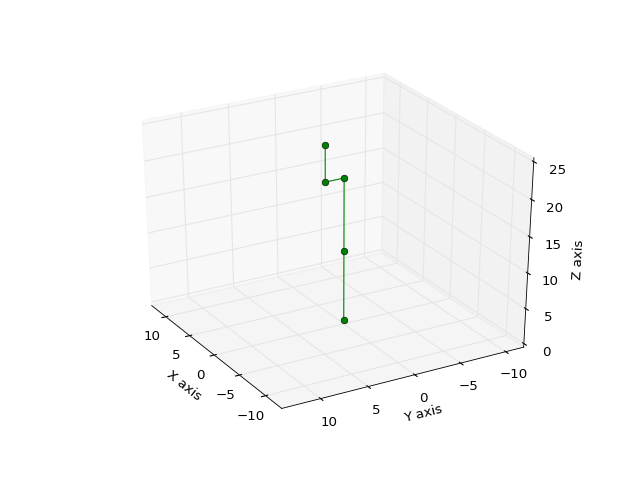

⎡⎡0⎤, ⎡0 ⎤, ⎡0 ⎤, ⎡0 ⎤, ⎡0 ⎤⎤
⎢⎢ ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎢⎢0⎥  ⎢0 ⎥  ⎢0 ⎥  ⎢2 ⎥  ⎢2 ⎥⎥
⎢⎢ ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎣⎣0⎦  ⎣10⎦  ⎣20⎦  ⎣20⎦  ⎣25⎦⎦

In [17]:
lengths = (10, 10, 2, 5)
angles = (0, 0, 0, 0)
graph_fk(lengths, angles)

### Inverse Kinematics

Given a 4 DOF system, there needs to be additional constraints aside from a point in space to avoid obtaining infinite solutions. For a general hand-like robot, it is helpful to define the direction of the vector created by the last two points. Redefine points $p_0$ to $p_4$ as $A$ to $E$.

The directional constraint, $\phi$, defines the angle formed by the vector $\overrightarrow{DE}$ and the normal of the XY-plane (Z axis). The point $(x, y, z)$ defines the desired target point in space.

In [23]:
x, y, z, phi = symbols('x y z phi', real=True)

Given $\phi$, it is possible to solve for $C$. Drawing out the diagram basically reveals two similar right triangles. Connecting all of the vertices reveals a trapazoid. The two diagonals are known. Two sides are known. Let the sides be $(a,b,c,d)$. $a = l_4\sin{\left(\phi\right)}$ and $d = \sqrt{a^2 + l_3^2}$. The diagonals are $l_3$ and the distance of the target from the origin. $c$ can be solved using the equations detailed [here](http://mathworld.wolfram.com/Trapezoid.html).

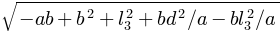

In [24]:
a, b, c, d = symbols('a, b, c, d', real=True)
c1 = solve(l3**2 - (a*b**2-a**2*b-a*c**2+b*d**2)/(b-a), c)[1]
c1

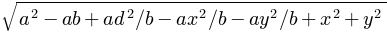

In [25]:
c2 = solve(x**2+y**2 - (a*b**2-a**2*b-a*d**2+b*c**2)/(b-a), c)[1]
c2

Setting both of the above equations equal to each other allows the solution for $b$ to be found. We need to find $\theta_0$, the angle difference caused by $l_3$. We can solve for the opposite leg of the right triangle and use it along with $b$ to find the desired angle.

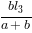

In [26]:
u = Symbol('u', positive=True)
u_soln = solve(a / (l3 - u) - b / u, u)[0]
u_soln

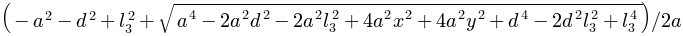

In [27]:
b_soln = solve(c1 - c2, b)[1]
simplify(b_soln.expand())

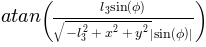

In [159]:
theta_0 = atan(u_soln.subs(b, b_soln) / b_soln).subs([(a, l4*sin(phi)),(d, sqrt(l3**2+(l4*sin(phi))**2))])
simplify(theta_0.expand())

We need to rewrite this equation because $\phi$ can cause this equation to be undefined and it is known analytically that $\phi$ does not play a role here.

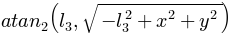

In [29]:
theta_0 = atan2(l3, sqrt(x**2+y**2-l3**2))
theta_0

The next step is to actually solve for C. We can define the vector $\overrightarrow{V} = \overrightarrow{CE}$. $C$ is really just $\overrightarrow{OC}$. Therefore, $\overrightarrow{C} = \overrightarrow{T} - \overrightarrow{CE}$. The vector $\overrightarrow{CE}$ can be described as two rotations of $\overrightarrow{{CE}_{0}}$ -- one rotation about the Z-axis and another rotation about a rotated Y-axis vector. $\overrightarrow{D}$ can be solved in a similar manner. Let $\overrightarrow{n}$ be the the Y-axis normal vector rotated by $R = \operatorname{atan2}{\left(y, x\right)} - \theta_0$.

The interesting thing to realize here is that there are two possible cases. In one case, the arm is not flipped. In the other case it is. We need to account for both cases.

In [30]:
theta0 = Symbol('theta_0', real=True)

# Define CD vector.
CD = Matrix((0, 0, l4))

# Define D.
D = Matrix((x, y, z)) - CD
D_sym = symbols('D_x D_y D_z', real=True)

# Define oE.
oE = (x, y, z)

# Rotate ny about Z-axis.
R1 = atan2(y, x) - theta0
R2 = atan2(y, x) + theta0

n1 = rotate(ny, R1, o, nz)
n2 = rotate(ny, R2, o, nz)
n = [n1, n2]

# Rotate D about rotated Y-normal.
D1 = rotate(D, phi, oE, n1)
D2 = rotate(D, phi, oE, n2)

D1 = simplify(D1.expand())
D2 = simplify(D2.expand())

D = [D1, D2]

# Output.
D

⎡⎡-l₄⋅sin(φ)⋅cos(θ₀ - atan2(y, x)) + x⎤, ⎡-l₄⋅sin(φ)⋅cos(θ₀ + atan2(y, x)) + x
⎢⎢                                    ⎥  ⎢                                    
⎢⎢l₄⋅sin(φ)⋅sin(θ₀ - atan2(y, x)) + y ⎥  ⎢-l₄⋅sin(φ)⋅sin(θ₀ + atan2(y, x)) + y
⎢⎢                                    ⎥  ⎢                                    
⎣⎣           -l₄⋅cos(φ) + z           ⎦  ⎣           -l₄⋅cos(φ) + z           

⎤⎤
⎥⎥
⎥⎥
⎥⎥
⎦⎦

In [31]:
n

⎡⎡sin(θ₀ - atan2(y, x))⎤, ⎡-sin(θ₀ + atan2(y, x))⎤⎤
⎢⎢                     ⎥  ⎢                      ⎥⎥
⎢⎢cos(θ₀ - atan2(y, x))⎥  ⎢cos(θ₀ + atan2(y, x)) ⎥⎥
⎢⎢                     ⎥  ⎢                      ⎥⎥
⎣⎣          0          ⎦  ⎣          0           ⎦⎦

In [32]:
# Define CE vector.
CE1 = Matrix((0, l3, l4))
CE2 = Matrix((0, -l3, l4))

# Define C.
C1 = Matrix((x, y, z)) - CE1
C2 = Matrix((x, y, z)) - CE2

C_sym = symbols('C_x C_y C_z', real=True)

# Rotate C about Z-axis.
C1 = rotate(C1, R1, oE, nz)
C2 = rotate(C2, R2, oE, nz)

# Rotate C about rotated Y-normal.
C1 = rotate(C1, phi, oE, n1)
C2 = rotate(C2, phi, oE, n2)

C1 = simplify(C1.expand())
C2 = simplify(C2.expand())

C = [C1, C2]

# Output.
[pretty(C[0], D[0], D_sym), pretty(C[1], D[1], D_sym)]

⎡⎡Dₓ - l₃⋅sin(θ₀ - atan2(y, x)) ⎤, ⎡Dₓ - l₃⋅sin(θ₀ + atan2(y, x)) ⎤⎤
⎢⎢                              ⎥  ⎢                              ⎥⎥
⎢⎢D_y - l₃⋅cos(θ₀ - atan2(y, x))⎥  ⎢D_y + l₃⋅cos(θ₀ + atan2(y, x))⎥⎥
⎢⎢                              ⎥  ⎢                              ⎥⎥
⎣⎣             D_z              ⎦  ⎣             D_z              ⎦⎦

Given $C$, it is possible to use the law of cosines to solve for $\theta_3$. $\theta_3$ can either be positive or negative.

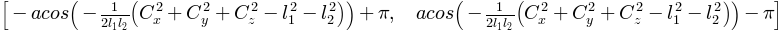

In [33]:
theta_3 = pi - acos((l1**2 + l2**2 - C[1].norm()**2) / (2 * l1 * l2))

sol1 = pretty(theta_3, C[1], C_sym)
sol2 = -sol1
theta_3 = [sol1, sol2]
theta_3

We can solve for $\theta_2$ by assuming that $B$ still rests on the Z-axis. Define $C^{\prime\prime}$ as the point $C$ with only $\theta_3$. Define $C^{\prime}$ as the point $C$ with only $\theta_2$ and $\theta_3$. $C^{\prime}_z$ must be equal to $C_z$ to form a radius for $\theta_1$ to complete. It is better to solve for the equation involving z rather than x and y, because $\theta_1$ does not impact z.

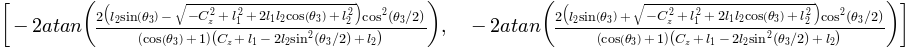

In [34]:
C_pp = (l2 * sin(theta3), 0, l1 + l2 * cos(theta3))
C_p = rotate(C_pp, theta2, o, ny)
theta_2 = solve(C_p[2] - C_sym[2], theta2)
theta_2

It is not immediately evident which solution to pick for the non-flipped vs. flipped. In fact, it basically is not evident at all. Test shows that the first solution works for non-flipped and the second for flipped. However, they flip when $x^2 + y^2 < l_3^2 + (l_4 \sin{(\phi)})^2$ and $\sin{(\phi)} > 0$. This is an observed result from extensive testing. I am sure there is good mathematical justification, but it is probably to difficult to derive from equations.

$\theta_1$ can actually be by solved using the forward kinematic equations for $C$. Assuming $\theta_1$ is 0, compute the current angle with the x-axis. Then, simply swing around. It might be tempting to use $C$, but there can be issues because it can sometimes be on the Z-axis. Using $D$ is better as it cannot be on the Z-axis unless $l_3$ is zero (in that case it does't matter anyway since $\theta_0$ will be zero).

In [326]:
theta_1 = atan2(D_sym[1], D_sym[0]) - atan2(p3[1].subs(theta1, 0), simplify(p3[0].subs(theta1, 0)))
theta_1

We can now solve for $\theta_4$. Define two vectors, $\overrightarrow{DE}$ and $\overrightarrow{BC}$. $B$ can be solved using the forward kinematics equation. The dot product can be used to determine the angle. The sign can be determined using the cross product. Define $s$ as the sign. Account for multiple solutions due to inverse cosine. Testing reveals that the second solution applies to the flipped case.

$$s = \operatorname{sgn}{\left[ \overrightarrow{n} \cdot \left( \overrightarrow{BC} \times \overrightarrow{DE} \right) \right] }$$

$$
\left[ 
s \cdot \operatorname{acos}{\left( \frac{\overrightarrow{BC} \cdot \overrightarrow{DE} }{l_2 l_4} \right)}, \quad
-s \cdot \operatorname{acos}{\left( \frac{\overrightarrow{BC} \cdot \overrightarrow{DE} }{l_2 l_4} \right)}
\right]
$$

For most constraint conditions of $(x, y, z, \phi)$, there are at most four solutions (and usually four solutions). The kinematic solution is stable around singularities. In cases where less than four solutions exist (i.e. one or two), all four equations will agree on these solutions. There is no known case of three unique solutions.

### Jacobian Analysis

We can define the forward Jacobian matrix to assist in computing velocities and torques. First, we need to compute the Jacobian for the linear velocity, $J_v(\theta)$.

In [330]:
wrt = Matrix((theta1, theta2, theta3, theta4))
J_v = simplify(p4).jacobian(wrt)
J_v

⎡-l₁⋅sin(θ₁)⋅sin(θ₂) - l₂⋅sin(θ₁)⋅sin(θ₂ + θ₃) - l₃⋅cos(θ₁) - l₄⋅sin(θ₁)⋅sin(θ
⎢                                                                             
⎢l₁⋅sin(θ₂)⋅cos(θ₁) + l₂⋅sin(θ₂ + θ₃)⋅cos(θ₁) - l₃⋅sin(θ₁) + l₄⋅sin(θ₂ + θ₃ + 
⎢                                                                             
⎣                                            0                                

₂ + θ₃ + θ₄)  l₁⋅cos(θ₁)⋅cos(θ₂) + l₂⋅cos(θ₁)⋅cos(θ₂ + θ₃) + l₄⋅cos(θ₁)⋅cos(θ₂
                                                                              
θ₄)⋅cos(θ₁)   l₁⋅sin(θ₁)⋅cos(θ₂) + l₂⋅sin(θ₁)⋅cos(θ₂ + θ₃) + l₄⋅sin(θ₁)⋅cos(θ₂
                                                                              
                         -l₁⋅sin(θ₂) - l₂⋅sin(θ₂ + θ₃) - l₄⋅sin(θ₂ + θ₃ + θ₄) 

 + θ₃ + θ₄)  l₂⋅cos(θ₁)⋅cos(θ₂ + θ₃) + l₄⋅cos(θ₁)⋅cos(θ₂ + θ₃ + θ₄)  l₄⋅cos(θ₁
                                                                              
 + θ₃ + θ₄)  l₂⋅sin(θ₁)⋅cos(θ₂ + θ₃) + l₄⋅sin(θ₁)⋅

We also need to define the Jacobian of angular velocities, $J_\omega(\theta)$.

In [331]:
w = Matrix((0, theta2 + theta3 + theta4, theta1))
J_w = w.jacobian(wrt)
J_w

⎡0  0  0  0⎤
⎢          ⎥
⎢0  1  1  1⎥
⎢          ⎥
⎣1  0  0  0⎦

We can combine the two results to get the full Jacobian matrix, $J_{ee}(\theta)$.

In [332]:
J_ee = Matrix((J_v, J_w))
J_ee

⎡-l₁⋅sin(θ₁)⋅sin(θ₂) - l₂⋅sin(θ₁)⋅sin(θ₂ + θ₃) - l₃⋅cos(θ₁) - l₄⋅sin(θ₁)⋅sin(θ
⎢                                                                             
⎢l₁⋅sin(θ₂)⋅cos(θ₁) + l₂⋅sin(θ₂ + θ₃)⋅cos(θ₁) - l₃⋅sin(θ₁) + l₄⋅sin(θ₂ + θ₃ + 
⎢                                                                             
⎢                                            0                                
⎢                                                                             
⎢                                            0                                
⎢                                                                             
⎢                                            0                                
⎢                                                                             
⎣                                            1                                

₂ + θ₃ + θ₄)  l₁⋅cos(θ₁)⋅cos(θ₂) + l₂⋅cos(θ₁)⋅cos(θ₂ + θ₃) + l₄⋅cos(θ₁)⋅cos(θ₂
                                                   

From the Jacobian, the velocities and torque can be related. This ensures if a particular operation is possible.

$$\dot{x} = J \dot{\theta}$$

$$\tau = J^T F$$

### Testing

In [322]:
def ik(lengths, target, p, sys):
   
    sub1 = list(zip((l1, l2, l3, l4), lengths))
    sub2 = list(zip((x, y, z), target))
    sub3 = [(phi, p)]
    
    sub = sub1 + sub2 + sub3
    
    theta0_ = N(theta_0.subs(sub))
    sub.append((theta0, theta0_))
    
    D_ = N(D[sys].subs(sub))
    C_ = N(C[sys].subs(sub))
    
    sub4 = list(zip(C_sym, C_)) + list(zip(D_sym, D_))
    sub += sub4
    
    theta3_ = N(theta_3[1].subs(sub))
    sub.append((theta3, theta3_))
  
    print(N(C_.subs(sub)))
    print(N(D_.subs(sub)))

    theta2_ = N(theta_2[0].subs(sub))
    sub.append((theta2, theta2_))
    
    theta1_ = N(theta_1[0].subs(sub))
    sub.append((theta1, theta1_))
    
    n_ = N(n[sys].subs(sub))
    target = Matrix(target)
    
    bx = l1 * sin(theta2) * cos(theta1)
    by = l1 * sin(theta1) * sin(theta2)
    bz = l1 * cos(theta2)
    b = Matrix((bx, by, bz))
    B_ = N(b.subs(sub))
    
    BC = N(C_ - B_)
    DE = N(target - D_)
    s = sign(n_.dot(BC.cross(DE)))
    
    theta4_ = N(s*acos(BC.dot(DE) / (BC.norm() * DE.norm())))
    theta4_ = [theta4_, -theta4_]
    theta4_ = theta4_[sys]
    sub.append((theta4, theta4_)) 

    return theta1_, theta2_, theta3_, theta4_

In [323]:
def test_system(lengths, target, p, sys = 0):
    angles = ik(lengths, target, p, sys)
    points = graph_fk(lengths, angles)
    print(angles)
    if all(round(N(points[-1][i]), 5) == round(N(target[i]), 5) for i in range(3)):
        print('Test passed!')
    else:
        print('Test failed!')
        
    return points


Matrix([
[   0],
[   0],
[10.0]])
Matrix([
[   0],
[   0],
[10.0]])


<IPython.core.display.Javascript object>


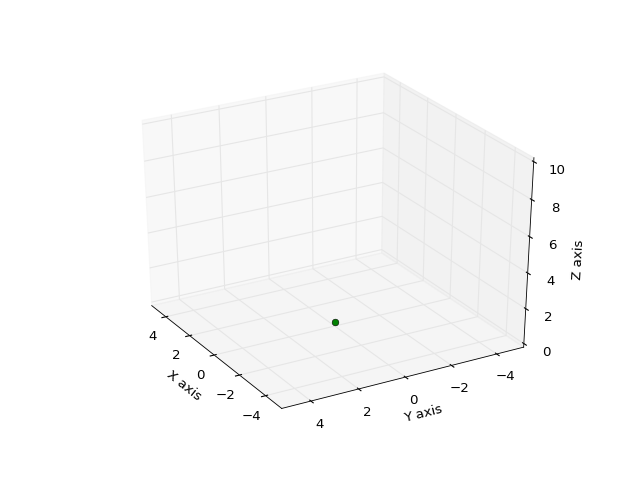

(nan, 1.04719757184425, -2.09439510239320, nan)
Test failed!


⎡⎡0⎤, ⎡      nan       ⎤, ⎡nan ⎤, ⎡nan ⎤, ⎡nan⎤⎤
⎢⎢ ⎥  ⎢                ⎥  ⎢    ⎥  ⎢    ⎥  ⎢   ⎥⎥
⎢⎢0⎥  ⎢      nan       ⎥  ⎢nan ⎥  ⎢nan ⎥  ⎢nan⎥⎥
⎢⎢ ⎥  ⎢                ⎥  ⎢    ⎥  ⎢    ⎥  ⎢   ⎥⎥
⎣⎣0⎦  ⎣4.99999982118607⎦  ⎣10.0⎦  ⎣10.0⎦  ⎣nan⎦⎦

In [325]:
lengths = (10, 10, 0, 5)
# target = (4.4722, 3, 10)
# target = (-4.4722, 3, 10)
# target = (1, 3.0414, 10) > pi / 6
target = (4, 3, 10)
test_system(lengths, target, pi / 2)

<IPython.core.display.Javascript object>


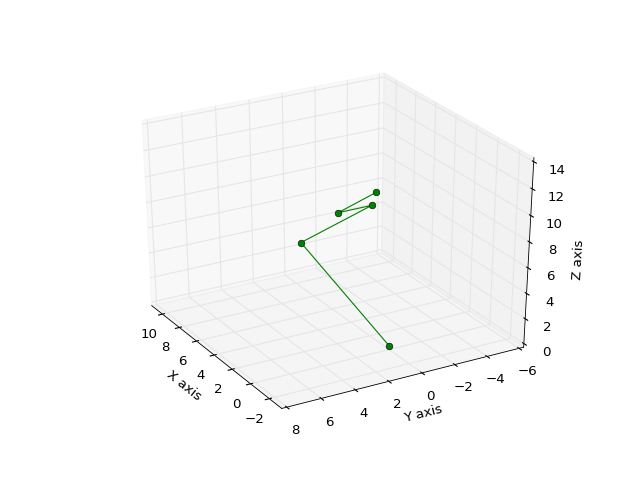

⎡⎡0⎤, ⎡9.41485956468907⎤, ⎡1.92820323027546⎤, ⎡1.92820323027546⎤, ⎡-1.81512493
⎢⎢ ⎥  ⎢                ⎥  ⎢                ⎥  ⎢                ⎥  ⎢           
⎢⎢0⎥  ⎢       0        ⎥  ⎢       0        ⎥  ⎢       2        ⎥  ⎢        2  
⎢⎢ ⎥  ⎢                ⎥  ⎢                ⎥  ⎢                ⎥  ⎢           
⎣⎣0⎦  ⎣3.37052212233991⎦  ⎣      10.0      ⎦  ⎣      10.0      ⎦  ⎣13.31473893

693134⎤⎤
      ⎥⎥
      ⎥⎥
      ⎥⎥
88301 ⎦⎦

In [267]:
angles = (0, 1.22701218606758, -2.07305919316747, 0)
points = graph_fk(lengths, angles)
points

<IPython.core.display.Javascript object>


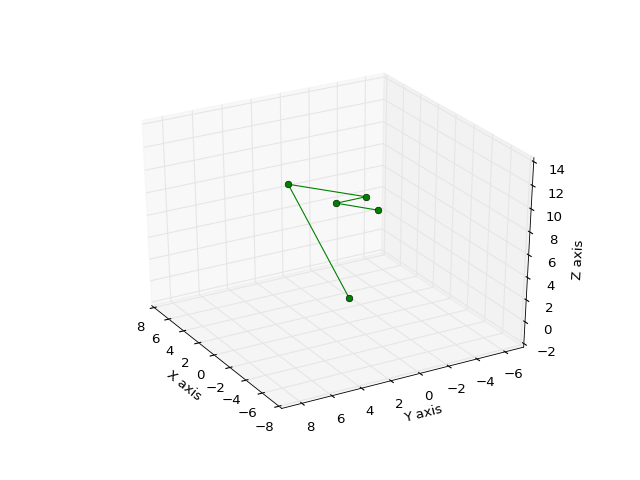

⎡⎡0⎤, ⎡7.48665633441358⎤, ⎡-1.92820323027551⎤, ⎡-1.92820323027551⎤, ⎡-6.635633
⎢⎢ ⎥  ⎢                ⎥  ⎢                 ⎥  ⎢                 ⎥  ⎢         
⎢⎢0⎥  ⎢       0        ⎥  ⎢        0        ⎥  ⎢        2        ⎥  ⎢        2
⎢⎢ ⎥  ⎢                ⎥  ⎢                 ⎥  ⎢                 ⎥  ⎢         
⎣⎣0⎦  ⎣6.62947787766013⎦  ⎣      10.0       ⎦  ⎣      10.0       ⎦  ⎣11.685261

01262005⎤⎤
        ⎥⎥
        ⎥⎥
        ⎥⎥
0611699 ⎦⎦

In [268]:
angles = (0, 0.846047007099885, -2.07305919316747, 0)
points = graph_fk(lengths, angles)
points